Clustering using Hierarchical Clustering
========================================

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.utils import simple_preprocess

from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE

In [2]:
parts_name = "c_nurse_doc2vec_embedding"
title_name = "c_nurse"

In [3]:
parts = pd.read_feather(f"dataset/{parts_name}-parts.feather")
titles = pd.read_feather(f"dataset/{title_name}-titles.feather")

In [4]:
parts.head()

,rid,pid,rord,srord,text,stext,title,stitle,label,embedding
0,1678764,2,1,3,"PNS: A pos, Ab neg, HBSAg neg, RPR NR, RI, GB...","A pos, Ab neg, HBSAg neg, RPR NR, RI, GBS neg....",PNS,pns,183,"[0.43021446, -0.6662299, 1.200484, -0.68246704..."
1,1678764,2,1,6,Assessment/plan:\nTerm male infant with increa...,Term male infant with increased risk of sepsis...,Assessment/plan,assessment/plan,42,"[-0.04399224, -0.59779483, 0.071669385, -0.551..."
2,1260685,3,1,0,MICU NSG PROG NOTE: days\nRemains stable on hi...,"days\nRemains stable on high dose neo, taperin...",MICU NSG PROG NOTE,micu nsg prog note,700,"[0.0025770026, -1.3833206, 0.19549513, -0.4590..."
3,1260685,3,1,2,CARDIAC: Maintaining map>60 on neo and levofed...,Maintaining map>60 on neo and levofed. He has ...,CARDIAC,cardiac,17,"[-0.5564191, 0.41284, 1.6669538, -0.50814295, ..."
4,1260685,3,1,3,RESP: good abg. good oxygenation. Strong cough...,good abg. good oxygenation. Strong cough. Has ...,RESP,resp,0,"[-0.30293128, -0.37995958, 0.49376696, -0.1509..."


Group by title and average embeddings

In [5]:
grouped = parts.groupby('label')['embedding'].apply(list).reset_index(name='emb_list')

In [6]:
grouped.head()

,label,emb_list
0,0,"[[-0.30293128, -0.37995958, 0.49376696, -0.150..."
1,1,"[[0.123717956, 0.9255205, -0.39909598, -0.4063..."
2,2,"[[-1.3192905, -0.09338913, 0.56800675, -0.8386..."
3,3,"[[-0.32443637, -0.22090971, 0.16070324, 0.3998..."
4,4,"[[0.2510399, -0.5522189, 0.70647895, -0.636594..."


In [7]:

def average_embeddings(emb_list):
    return np.mean(emb_list, axis=0)

In [8]:
grouped['avg_embedding'] = grouped['emb_list'].apply(average_embeddings)

In [9]:
grouped.head()

,label,emb_list,avg_embedding
0,0,"[[-0.30293128, -0.37995958, 0.49376696, -0.150...","[0.21475144, -0.244166, 0.23563239, -0.2913499..."
1,1,"[[0.123717956, 0.9255205, -0.39909598, -0.4063...","[-0.11446254, -0.024146996, -0.15886617, -0.59..."
2,2,"[[-1.3192905, -0.09338913, 0.56800675, -0.8386...","[0.2700717, -0.087540925, 0.22553557, -0.60695..."
3,3,"[[-0.32443637, -0.22090971, 0.16070324, 0.3998...","[0.17024668, 0.16453648, -0.056489807, -0.0999..."
4,4,"[[0.2510399, -0.5522189, 0.70647895, -0.636594...","[0.1825122, -0.18174066, 0.22360943, -0.352819..."


In [11]:
X = np.vstack(grouped['avg_embedding'].values)


Silhouette

In [16]:
from sklearn.metrics import silhouette_score

scores = []
for k in range(2, 150, 10):
    clustering = AgglomerativeClustering(n_clusters=k)
    labels = clustering.fit_predict(X)
    score = silhouette_score(X, labels)
    scores.append((k, score))

# To find the best k
best_k = max(scores, key=lambda x: x[1])
print(f"Best k: {best_k[0]}, Silhouette Score: {best_k[1]:.4f}")

Best k: 2, Silhouette Score: 0.1324


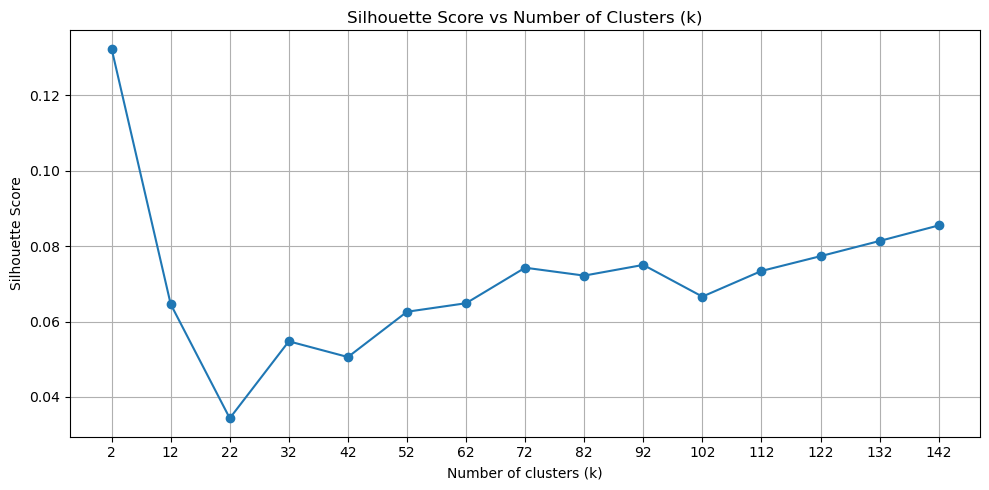

In [17]:
# Extract k-values and scores separately
k_vals, sil_scores = zip(*scores)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(k_vals, sil_scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters (k)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.xticks(k_vals)  # Show k values on x-axis
plt.tight_layout()
plt.show()


Cluster the average embeddings

In [18]:
X = np.vstack(grouped['avg_embedding'].values)
clustering = AgglomerativeClustering(n_clusters=72)
labels = clustering.fit_predict(X)
grouped['cluster'] = labels

T-SNE visualization

In [19]:
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

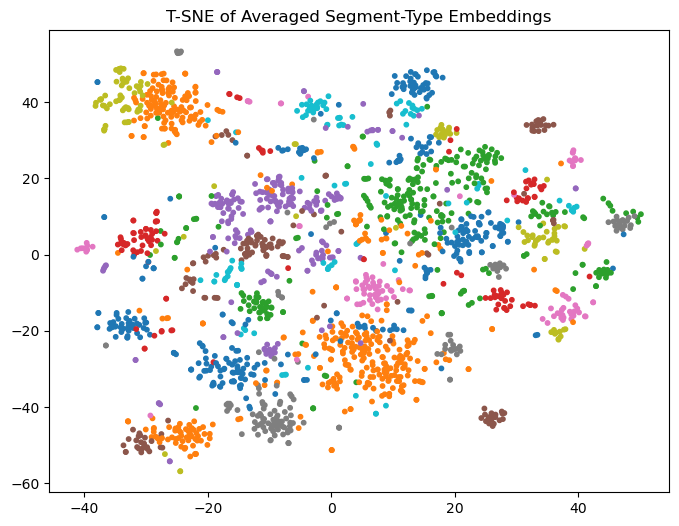

In [21]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', s=10)
# for i, row in grouped.iterrows():
    # plt.text(X_2d[i, 0] + 0.03, X_2d[i, 1] + 0.03, row['label'], fontsize=3)

plt.title("T-SNE of Averaged Segment-Type Embeddings")
plt.show()